## Question 1: **Answer**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3

In [ ]:
def add_data_to_database(cars_country, cars_details, cars_price):
    try:
        country = pd.read_csv(cars_country)
        details = pd.read_csv(cars_details)
        price = pd.read_csv(cars_price)
        # Connecting to database
        engine = sqlite3.connect("cars_data.db")
        # creating three tables
        country.to_sql("cars_country", con=engine, index = False)
        details.to_sql("cars_details", con=engine, index = False)
        price.to_sql("cars_price", con=engine, index = False)
    except Exception as e:
            print(f"Error: {e}")

cars_country = "/content/cars_country.csv"
cars_details =  "/content/cars_details.csv"
cars_price = "/content/cars_price.csv"

add_data_to_database(cars_country, cars_details, cars_price)

In [3]:
# Loading SQL extension
%load_ext sql

In [4]:
# Connecting to the database
%sql sqlite:///cars_data.db

In [5]:
# Default to duplicated style
%config SqlMagic.style = '_DEPRECATED_DEFAULT'

In [6]:
%%sql
SELECT * FROM cars_country;

 * sqlite:///cars_data.db
Done.


origin,country
1,USA
2,Europe
3,Japan


In [7]:
%%sql
SELECT * FROM cars_details
LIMIT 5;

 * sqlite:///cars_data.db
Done.


ID,mpg,cylinders,displacement,horsepower,weight,acceleration,model,origin,car_name
1,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
2,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
3,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
4,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
5,17.0,8,302.0,140,3449,10.5,70,1,ford torino


In [8]:
%%sql
SELECT * FROM cars_price
LIMIT 5;

 * sqlite:///cars_data.db
Done.


ID,price
1,25561.59078
2,24221.42273
3,27240.84373
4,33684.96888
5,20000.0


## Question 2: **Answer**

In [9]:
%%sql
SELECT
    cc.country,
    COUNT(DISTINCT(cd.car_name))
    AS number_of_cars_in_us
FROM cars_details cd
INNER JOIN cars_country cc
-- Joining tables on origin column
ON cd.origin = cc.origin
WHERE cc.country = 'USA'
-- Grouping by country to get the count per country
GROUP BY cc.country;

 * sqlite:///cars_data.db
Done.


country,number_of_cars_in_us
USA,187


## Question 3: **Answer**

In [10]:
%%sql
SELECT
    SUM(CASE WHEN country = 'Europe' THEN unique_cars ELSE 0 END)
    AS unique_cars_europe,
    SUM(CASE WHEN country = 'Japan' THEN unique_cars ELSE 0 END)
    AS unique_cars_japan,
    SUM(unique_cars) AS combined_total
FROM (
    SELECT
        cars_country.country AS country,
        COUNT(DISTINCT cars_details.car_name) AS unique_cars
    FROM cars_details
    INNER JOIN cars_country
    ON cars_details.origin = cars_country.origin
    WHERE cars_country.country IN ('Europe', 'Japan')
    GROUP BY cars_country.country
) AS unique_cars_per_country;

 * sqlite:///cars_data.db
Done.


unique_cars_europe,unique_cars_japan,combined_total
58,60,118


## Question 4: **Answer**

In [11]:
%%sql
-- Joining three tables to get required details
WITH most_expensive_car AS (
    SELECT
        cars_details.car_name,
        cars_details.cylinders,
        cars_country.country,
        cars_price.price
    FROM cars_details
    INNER JOIN cars_price
    ON cars_details.ID = cars_price.ID
    INNER JOIN cars_country
    ON cars_details.origin = cars_country.origin
    ORDER BY cars_price.price DESC
)
-- Retrieving the most expensive car
SELECT
    car_name,
    cylinders,
    country,
    price
FROM most_expensive_car
WHERE price = (SELECT MAX(price) FROM most_expensive_car);

 * sqlite:///cars_data.db
Done.


car_name,cylinders,country,price
plymouth fury gran sedan,8,USA,53745.93806


## Question 5: **Answer**

In [12]:
%%sql
-- Calculating total revenue per car
WITH car_revenues AS (
    SELECT
        cars_details.car_name,
        SUM(cars_price.price) AS total_revenue
    FROM cars_details
    INNER JOIN cars_price
    ON cars_details.ID = cars_price.ID
    GROUP BY cars_details.car_name
)
-- Retrieving car with most revenue
SELECT
    car_name,
    ROUND(total_revenue, 2) AS total_revenue
FROM car_revenues
WHERE total_revenue = (SELECT MAX(total_revenue) FROM car_revenues);

 * sqlite:///cars_data.db
Done.


car_name,total_revenue
ford pinto,203385.99


## Question 6: **Answer**

In [13]:
%%sql
WITH revenue_per_region AS (
    SELECT
        cars_country.country AS region,
        SUM(cars_price.price) AS total_revenue
    FROM cars_details
    INNER JOIN cars_price
    ON cars_details.ID = cars_price.ID
    INNER JOIN cars_country
    ON cars_details.origin = cars_country.origin
    GROUP BY cars_country.country
)
SELECT
    region,
    printf('%20s', ROUND(total_revenue, 2)) AS total_revenue
FROM revenue_per_region
ORDER BY total_revenue ASC;

 * sqlite:///cars_data.db
Done.


region,total_revenue
Japan,2393364.6
Europe,2117546.62
USA,7303509.21


## Question 6 Part B: **Answer**

In [14]:
# Passing query to a variable
query = """

WITH revenue_per_region AS (
    SELECT
        cars_country.country AS region,
        SUM(cars_price.price) AS total_revenue
    FROM cars_details
    INNER JOIN cars_price
    ON cars_details.ID = cars_price.ID
    INNER JOIN cars_country
    ON cars_details.origin = cars_country.origin
    GROUP BY cars_country.country
)
SELECT
    region,
    ROUND(total_revenue, 2) AS total_revenue
FROM revenue_per_region;

"""
# Creating connection to the database
conn = sqlite3.connect('cars_data.db')
# creating a DataFrame
df = pd.read_sql_query(query, conn)
print(df)

   region  total_revenue
0  Europe     2117546.62
1   Japan     2393364.60
2     USA     7303509.21


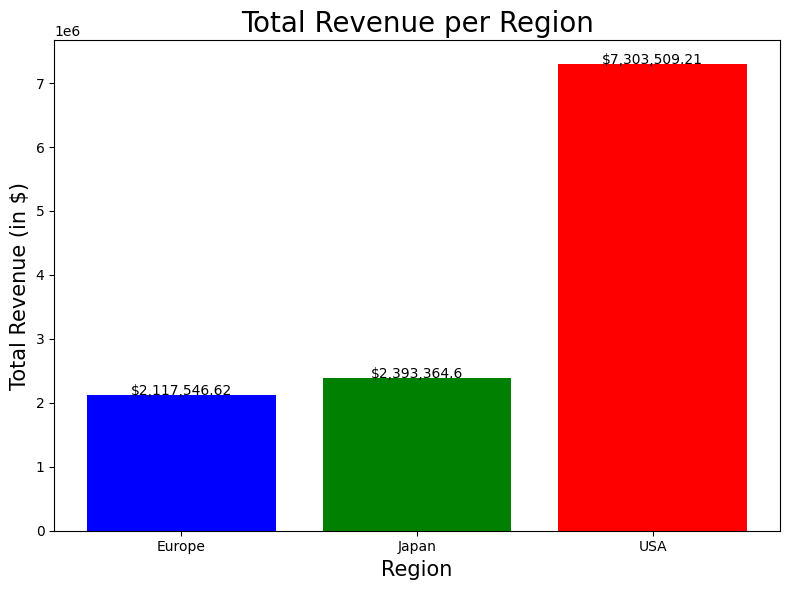

In [15]:
# Extracting from DataFrame
regions = df['region']
total_revenue = df['total_revenue']

# Create the bar graph
plt.figure(figsize=(8, 6))
plt.bar(regions, total_revenue, color=['blue', 'green', 'red'])
plt.title('Total Revenue per Region', fontsize=20)
plt.xlabel('Region', fontsize=15)
plt.ylabel('Total Revenue (in $)', fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
# Adding text on top of the bars
for i, value in enumerate(total_revenue):
    plt.text(i, value, f"${value:,}", ha='center', fontsize=10, color='black')
plt.tight_layout()
plt.show()

## Question 7: **Answer**

In [16]:
%%sql
-- Calculating revenue per car
WITH revenue_per_car_name AS (
    SELECT
        cars_details.car_name,
        ROUND(SUM(cars_price.price), 2) AS total_revenue
    FROM cars_details
    JOIN cars_price
        ON cars_details.ID = cars_price.ID
    GROUP BY cars_details.car_name
)
-- Retrieving top and bottom revenue
SELECT
    (SELECT MAX(total_revenue) FROM revenue_per_car_name)
    AS top_car_revenue,
    (SELECT MIN(total_revenue) FROM revenue_per_car_name)
    AS bottom_car_revenue,
    (SELECT MAX(total_revenue) - MIN(total_revenue) FROM revenue_per_car_name)
    AS difference_in_revenue;

 * sqlite:///cars_data.db
Done.


top_car_revenue,bottom_car_revenue,difference_in_revenue
203385.99,5975.71,197410.28
